In [14]:
import pandas as pd
import numpy as np

# algorithms
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import dummy
from sklearn import linear_model
from sklearn import tree
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder

# evaluation
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure  


# Cleaning the Data

In [2]:
# Load the CSV file for the training dataset
data_train = pd.read_csv('train.csv')
df_train = pd.DataFrame(data_train)

df_train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [4]:
df_train = df_train.drop('Id', axis=1)
df_train

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [5]:
# Check if there are any missing values in the DataFrame
has_missing = data_train.isnull().values.any()
print("Are there any missing values?", has_missing)

#df_train.isna().sum()

# missing_summary = pd.DataFrame({
#     'missing_count': df_train.isnull().sum(),
#     'missing_percentage': df_train.isnull().mean() * 100
# })
# print(missing_summary)

# Only show columns with missing values
df_train.isnull().sum()[df_train.isnull().sum() > 0]


Are there any missing values? True


LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

From these missing columns, NaN has meaning for some of them. The ones with no meaning are the ones I will remove. These are:

LotFrontage

Electrical

In [6]:
df_train = df_train.dropna(subset=['LotFrontage', 'Electrical'])

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1200 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1200 non-null   int64  
 1   MSZoning       1200 non-null   object 
 2   LotFrontage    1200 non-null   float64
 3   LotArea        1200 non-null   int64  
 4   Street         1200 non-null   object 
 5   Alley          86 non-null     object 
 6   LotShape       1200 non-null   object 
 7   LandContour    1200 non-null   object 
 8   Utilities      1200 non-null   object 
 9   LotConfig      1200 non-null   object 
 10  LandSlope      1200 non-null   object 
 11  Neighborhood   1200 non-null   object 
 12  Condition1     1200 non-null   object 
 13  Condition2     1200 non-null   object 
 14  BldgType       1200 non-null   object 
 15  HouseStyle     1200 non-null   object 
 16  OverallQual    1200 non-null   int64  
 17  OverallCond    1200 non-null   int64  
 18  YearBuilt    

### Changing all columns to numerical quantities

In [9]:
#Change columns with 'Yes'/'No' to 1/0
yes_no_cols = [col for col in df_train.columns if set(df_train[col].unique()) == {'Yes', 'No'}]
for col in yes_no_cols:
    df_train[col] = df_train[col].map({'Yes': 1, 'No': 0})

# One-hot encode categorical variables


# Identify categorical and object columns
cat_cols = df_train.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Categorical columns to encode: {cat_cols}")
print(f"Number of categorical columns: {len(cat_cols)}")

# Initialize OneHotEncoder
# sparse_output=False returns a dense array instead of sparse matrix
# handle_unknown='ignore' will ignore unknown categories during transform
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop=None)

# Fit and transform the categorical columns
encoded_array = encoder.fit_transform(df_train[cat_cols])

# Get feature names for the encoded columns
encoded_feature_names = encoder.get_feature_names_out(cat_cols)

# Create a dataframe with the encoded features
df_encoded = pd.DataFrame(
    encoded_array, 
    columns=encoded_feature_names,
    index=df_train.index
)

# Drop original categorical columns and concatenate encoded columns
df_train_encoded = df_train.drop(columns=cat_cols)
df_train_encoded = pd.concat([df_train_encoded, df_encoded], axis=1)

# Convert boolean columns to integers (if any remain)
bool_cols = df_train_encoded.select_dtypes(include='bool').columns
if len(bool_cols) > 0:
    df_train_encoded[bool_cols] = df_train_encoded[bool_cols].astype(int)

print(f"\nOriginal shape: {df_train.shape}")
print(f"Encoded shape: {df_train_encoded.shape}")
print(f"\nFirst few rows:")
df_train_encoded.head()




Categorical columns to encode: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
Number of categorical columns: 43

Original shape: (1200, 80)
Encoded shape: (1200, 295)

First few rows:


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [11]:
df_train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1200 entries, 0 to 1459
Columns: 295 entries, MSSubClass to SaleCondition_Partial
dtypes: float64(261), int64(34)
memory usage: 2.7 MB


## ยังไม่ได้ทำำำำำ Applying the same method to the test data.

In [3]:
data_test = pd.read_csv('test.csv')
df_test = pd.DataFrame(data_test)

df_test

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


# Training Numeric Models :0

In [32]:
# setting up the data and target variables
data = df_train_encoded.drop('SalePrice', axis=1)
target = df_train_encoded['SalePrice']

# Splitting the training data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.1)

In [33]:
X_train

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1040,20,88.0,13125,5,4,1957,2000,67.0,168,682,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
239,50,52.0,8741,6,4,1945,1950,0.0,94,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
30,70,50.0,8500,4,4,1920,1950,0.0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1265,160,35.0,3735,7,5,1999,1999,218.0,450,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
411,190,100.0,34650,5,5,1955,1955,0.0,1056,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
627,80,80.0,9600,6,6,1955,1972,164.0,674,132,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
88,50,105.0,8470,3,2,1915,1982,0.0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
729,30,52.0,6240,4,5,1925,1950,0.0,152,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
905,20,80.0,9920,5,5,1954,1954,110.0,354,290,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


### Plotting for shits

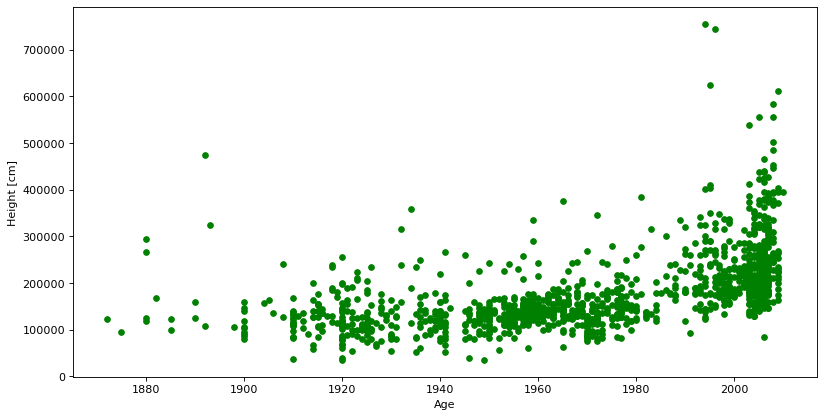

In [28]:
figure(figsize=(12, 6), dpi=80)
plt.plot(df_train_encoded['YearBuilt'], df_train_encoded['SalePrice'], marker='o', linestyle='', c = 'green', markersize=5)
plt.xlabel("Age")
plt.ylabel("Height [cm]")
plt.show()

count      1200.000000
mean     180781.539167
std       83423.406190
min       34900.000000
25%      127500.000000
50%      159467.000000
75%      213500.000000
max      755000.000000
Name: SalePrice, dtype: float64


/var/folders/34/91r13ymj4sv1jwnd5dkv2hc00000gp/T/ipykernel_28539/2374704891.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train_encoded['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4});


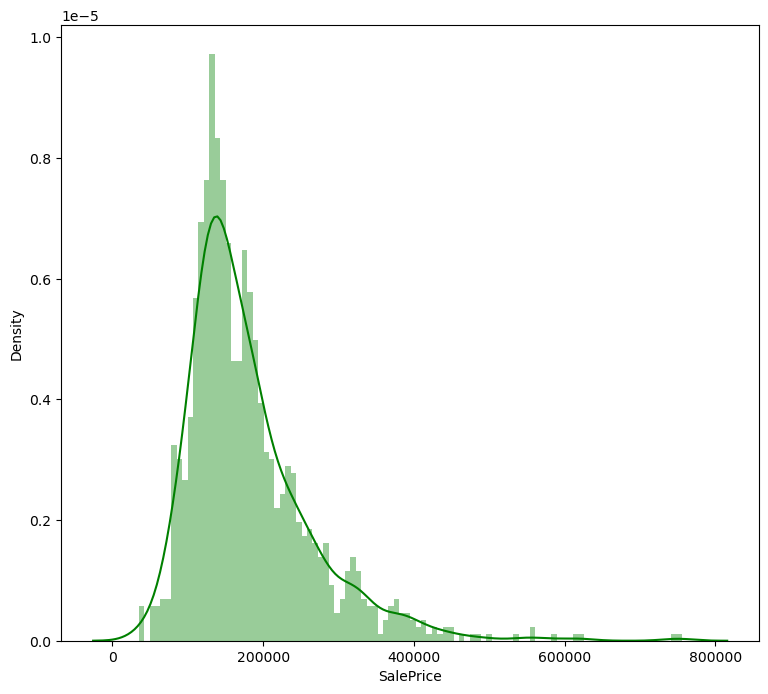

In [29]:
print(df_train_encoded['SalePrice'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(df_train_encoded['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4});

## Doing Numeric models

### Dummy Regressor

In [34]:
dum = dummy.DummyRegressor()
dum.fit(X_train, y_train)
y_pred = dum.predict(X_test)
y_pred


array([180414.875, 180414.875, 180414.875, 180414.875, 180414.875,
       180414.875, 180414.875, 180414.875, 180414.875, 180414.875,
       180414.875, 180414.875, 180414.875, 180414.875, 180414.875,
       180414.875, 180414.875, 180414.875, 180414.875, 180414.875,
       180414.875, 180414.875, 180414.875, 180414.875, 180414.875,
       180414.875, 180414.875, 180414.875, 180414.875, 180414.875,
       180414.875, 180414.875, 180414.875, 180414.875, 180414.875,
       180414.875, 180414.875, 180414.875, 180414.875, 180414.875,
       180414.875, 180414.875, 180414.875, 180414.875, 180414.875,
       180414.875, 180414.875, 180414.875, 180414.875, 180414.875,
       180414.875, 180414.875, 180414.875, 180414.875, 180414.875,
       180414.875, 180414.875, 180414.875, 180414.875, 180414.875,
       180414.875, 180414.875, 180414.875, 180414.875, 180414.875,
       180414.875, 180414.875, 180414.875, 180414.875, 180414.875,
       180414.875, 180414.875, 180414.875, 180414.875, 180414.

In [35]:
# Store the actual data and the predictions in a DataFrame for later
price_test = pd.DataFrame()
price_test["Actual_price"] = y_test
price_test["Dummy_price"] = y_pred

price_test

,Actual_price,Dummy_price
987,395192,180414.875
1360,189000,180414.875
887,135500,180414.875
744,180000,180414.875
1335,167900,180414.875
...,...,...
379,179000,180414.875
500,113000,180414.875
1411,140000,180414.875
324,242000,180414.875


In [37]:
print("Dummy MSE  \t{0:5.2f}".format( metrics.mean_squared_error(price_test["Actual_price"], price_test["Dummy_price"])))


Dummy MSE  	7909577590.43


### Linear Regression with all attributes

In [38]:
# Using Linear Regression
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)
y_pred

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values